Implementation of the 9-qubit surface code 

<!--  <img src="./images/9-qubit-image.png" width="300"/> -->
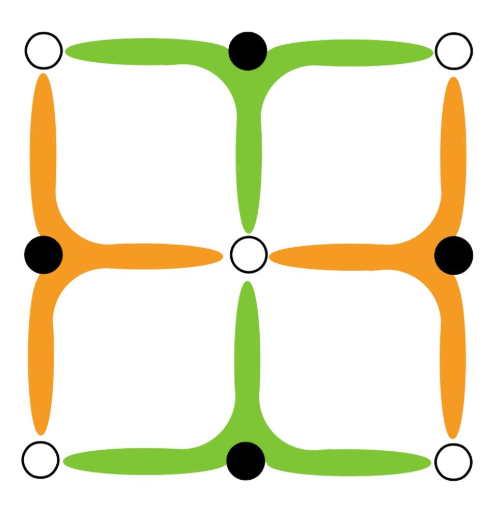


In [1]:
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister, transpile
from qiskit.quantum_info import partial_trace
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit.library import Initialize
from qiskit.circuit import Gate

Define Helper Functions to define the different input states for the data qubits 

In [2]:
# --- Helpers ---
def create_state(*amps):
    state = np.array(amps, dtype=complex)
    norm = np.linalg.norm(state)
    if norm == 0:
        raise ValueError("State cannot be all zeros.")
    return state / norm  # Normalize to unit vector

# Function to generate a normalized real-valued quantum state (5 qubits)
def random_real_state(num_qubits = 5):
    dim = 2 ** num_qubits
    real_amps = np.random.randn(dim)  # draw real numbers from normal distribution
    return create_state(*real_amps)

def logical_0_state():
    # Create a statevector with 32 entries (5 qubits)
    state_vector = np.zeros(32)
    # Initialize logical  0 state
    amp = 1 / np.sqrt(4)     # Set amplitudes
    state_vector[0] = amp      # |00000>
    state_vector[28] = amp     # |11100>
    state_vector[7] = amp      # |00111>
    state_vector[27] = amp     # |11011>
    return state_vector

def logical_1_state():
    # Initialize logical  1 state
    state_vector = np.zeros(32)
    amp = 1 / np.sqrt(4)

    state_vector[9] = amp      # |01001>
    state_vector[21] = amp      # |10101>
    state_vector[14] = amp      # |01110>
    state_vector[18] = amp      # |10010>
    return state_vector


Function to implement a very simple Error-model.
Errors are modeled as a list of quadruples, (l,i,j,k)
- l indicates the error type {x,y,z}
- i indicates the cycle on which the error should occur {0 till cycle}
- j indicates the  data qubit {0,1,2,3,4}
- k indicates if the error occurs on the first or the seond identity gate {0,1}

In [3]:
def add_errors(qc: QuantumCircuit, data_qubits: list, errors: list, cycle: int, step: int):
    # step = 0 for first identity gate, step = 1 for second identity gate
    
    # l indicates the error type {x,y,z}
    # i indicates the cycle on which the error should occur {0 till cycle}
    # j indicates the  data qubit {0,1,2,3,4}
    # k indicates if the error occurs on the first or the seond identity gate {0,1}
    for l, i, j, k in errors:
        if i == cycle and k == step:
            if l == 'x':
                qc.x(data_qubits[j])
            elif l == 'y':
                qc.y(data_qubits[j])
            elif l == 'z':
                qc.z(data_qubits[j])
            else:
                raise ValueError(f"Unknown error type: {l}")
        
    return qc

Define a function to generate the 9-qubit surface code, with a dynamic number of cycles, shots (in simulation), and what qubits to measure

In [23]:

def nine_qubit_surface_circuit(state_vector, cycles=1, shots_num=1, draw_bool=True, measure_data_bool=False, errors= []):
    # --- Registers ---
    mx1 = QuantumRegister(1, name='M_X1')
    mx2 = QuantumRegister(1, name='M_X2')
    mz1 = QuantumRegister(1, name='M_Z1')
    mz2 = QuantumRegister(1, name='M_Z2')
    a = QuantumRegister(1, name='a')
    b = QuantumRegister(1, name='b')
    c = QuantumRegister(1, name='c')
    d = QuantumRegister(1, name='d')
    e = QuantumRegister(1, name='e')
    # Of form (l,i,j,k)
    # l indicates the error type {x,y,z}
    # i indicates the cycle on which the error should occur {0 till cycles}
    # j indicates the  data qubit {0=a,1=b,2=c,3=d,4=e}
    # k indicates if the error occurs on the first or the seond identity gate {0,1}
    

    cr = ClassicalRegister(4*cycles, name='meas')
    qc = QuantumCircuit(mx1, mx2, mz1, mz2, a, b, c, d, e, cr)

    data_qubits = [a[0], b[0], c[0], d[0], e[0]]

    if measure_data_bool:
        cr_data = ClassicalRegister(5, name='data')
        qc.add_register(cr_data)

    # Reset
    qc.reset(qc.qubits)
    
    init_gate = Initialize(state_vector)
    qc.append(init_gate, [a[0], b[0], c[0], d[0], e[0]])
    
    # --- Cycles ---
    for i in range(cycles):
        # Prepare X ancillas
        qc.barrier(label=f"Cycle {i+1}")
        qc.h(mx1[0])
        qc.h(mx2[0])
        qc.id(mz1[0])
        qc.id(mz2[0])
    
        add_errors(qc, data_qubits, errors, i,0 )
        qc.barrier()

        # X stabilizer CNOTs
        qc.cx(mx1[0], a[0])
        qc.cx(mx1[0], b[0])
        qc.cx(mx1[0], c[0])
        qc.cx(mx2[0], c[0])
        qc.cx(mx2[0], d[0])
        qc.cx(mx2[0], e[0])
        qc.barrier()

        # Z stabilizer CNOTs
        qc.cx(a[0], mz1[0])
        qc.cx(c[0], mz1[0])
        qc.cx(d[0], mz1[0])
        qc.barrier()
        qc.cx(b[0], mz2[0])
        qc.cx(c[0], mz2[0])
        qc.cx(e[0], mz2[0])
        qc.barrier()
        
        # Rotate X ancillas back
        qc.h(mx1[0])
        qc.h(mx2[0])
        qc.id(mz1[0])
        qc.id(mz2[0])
    
        add_errors(qc, data_qubits, errors, i, 1)
        
        # Measure ancillas into classical bits
        qc.measure(mx1[0], cr[4*i])  # X1
        qc.measure(mx2[0], cr[4*i+1])  # X2
        qc.measure(mz1[0], cr[4*i+2])  # Z1
        qc.measure(mz2[0], cr[4*i+3])  # Z2
        

        if (i != cycles-1):
            # Reset qubits q0 and q3 to |0⟩ state
            qc.barrier()
            qc.reset(mx1[0])
            qc.reset(mx2[0])
            qc.reset(mz1[0])
            qc.reset(mz2[0])
        
    if measure_data_bool:
        # Measure only data qubits at the end
        qc.barrier()
        qc.measure(a[0], cr_data[0])
        qc.measure(b[0], cr_data[1])
        qc.measure(c[0], cr_data[2])
        qc.measure(d[0], cr_data[3])
        qc.measure(e[0], cr_data[4])
            
    # Run simulation
    simulator = Aer.get_backend('qasm_simulator')
    compiled = transpile(qc, simulator)
    result = simulator.run(compiled, shots=shots_num).result()
    counts = result.get_counts()
    
    if draw_bool:
        display(qc.draw('mpl'))

    
    # --- Ancilla analysis ---
    cycle_range = list(range(1, cycles + 1))
    mx1_vals, mx2_vals, mz1_vals, mz2_vals = [], [], [], []
    
    plt.figure(figsize=(10, 2.5))  # Smaller height
    if shots_num == 1:
        plt.title('Single-shot Ancilla Measurements Over Cycles', fontsize=16)
        plt.ylabel('Measurement Values',fontsize=13)

        bitstring = list(counts.keys())[0][::-1]
        ancilla_bits = bitstring[:4 * cycles]
        mx1_vals = [int(ancilla_bits[4 * i + 0]) for i in range(cycles)]
        mx2_vals = [int(ancilla_bits[4 * i + 1]) for i in range(cycles)]
        mz1_vals = [int(ancilla_bits[4 * i + 2]) for i in range(cycles)]
        mz2_vals = [int(ancilla_bits[4 * i + 3]) for i in range(cycles)]
    else:
        plt.title(f'Average ancilla measurements over cycles for {shots_num} shots',fontsize=16)
        plt.ylabel('Measurement Average Values')

        mx1_vals = [0] * cycles
        mx2_vals = [0] * cycles
        mz1_vals = [0] * cycles
        mz2_vals = [0] * cycles

        for bitstring, count in counts.items():
            bits = bitstring[::-1][:4 * cycles]
            for i in range(cycles):
                mx1_vals[i] += count * int(bits[4 * i + 0])
                mx2_vals[i] += count * int(bits[4 * i + 1])
                mz1_vals[i] += count * int(bits[4 * i + 2])
                mz2_vals[i] += count * int(bits[4 * i + 3])

        mx1_vals = [val / shots_num for val in mx1_vals]
        mx2_vals = [val / shots_num for val in mx2_vals]
        mz1_vals = [val / shots_num for val in mz1_vals]
        mz2_vals = [val / shots_num for val in mz2_vals]
        

    plt.step(cycle_range, mx1_vals, where='mid', label='$M_{X1}$', marker='*', alpha=0.9, linewidth=2)
    plt.step(cycle_range, mx2_vals, where='mid', label='$M_{X2}$', linestyle='--', marker='o',linewidth=2, alpha=0.7)
    plt.step(cycle_range, mz1_vals, where='mid', label='$M_{Z1}$', marker='s',linewidth=2, alpha=0.7)
    plt.step(cycle_range, mz2_vals, where='mid', label='$M_{Z2}$', linestyle='--', marker='s',linewidth=2, alpha=0.7)

    plt.xticks(cycle_range, fontsize=14)
    plt.yticks([0, 1], fontsize=14)
    plt.xlabel('Cycle', fontsize=14)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()
    
    if measure_data_bool:
        data_counts = {}
        for bitstring, count in counts.items():
            abcde = bitstring[:5] # first 5 bits correspond to cr_data
            data_counts[abcde] = data_counts.get(abcde, 0) + count

        print("\nFinal states of data qubits |abcde⟩:")
        for state, count in sorted(data_counts.items()):
            print(f"|{state}>: {count} shots ({count/shots_num*100:.2f}%)")

        plt.figure(figsize=(8, 4))
        plt.bar(data_counts.keys(), data_counts.values())
        plt.title("Final states of data qubits |abcde⟩")
        plt.xlabel("Data Qubit State")
        plt.ylabel("Counts")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
            

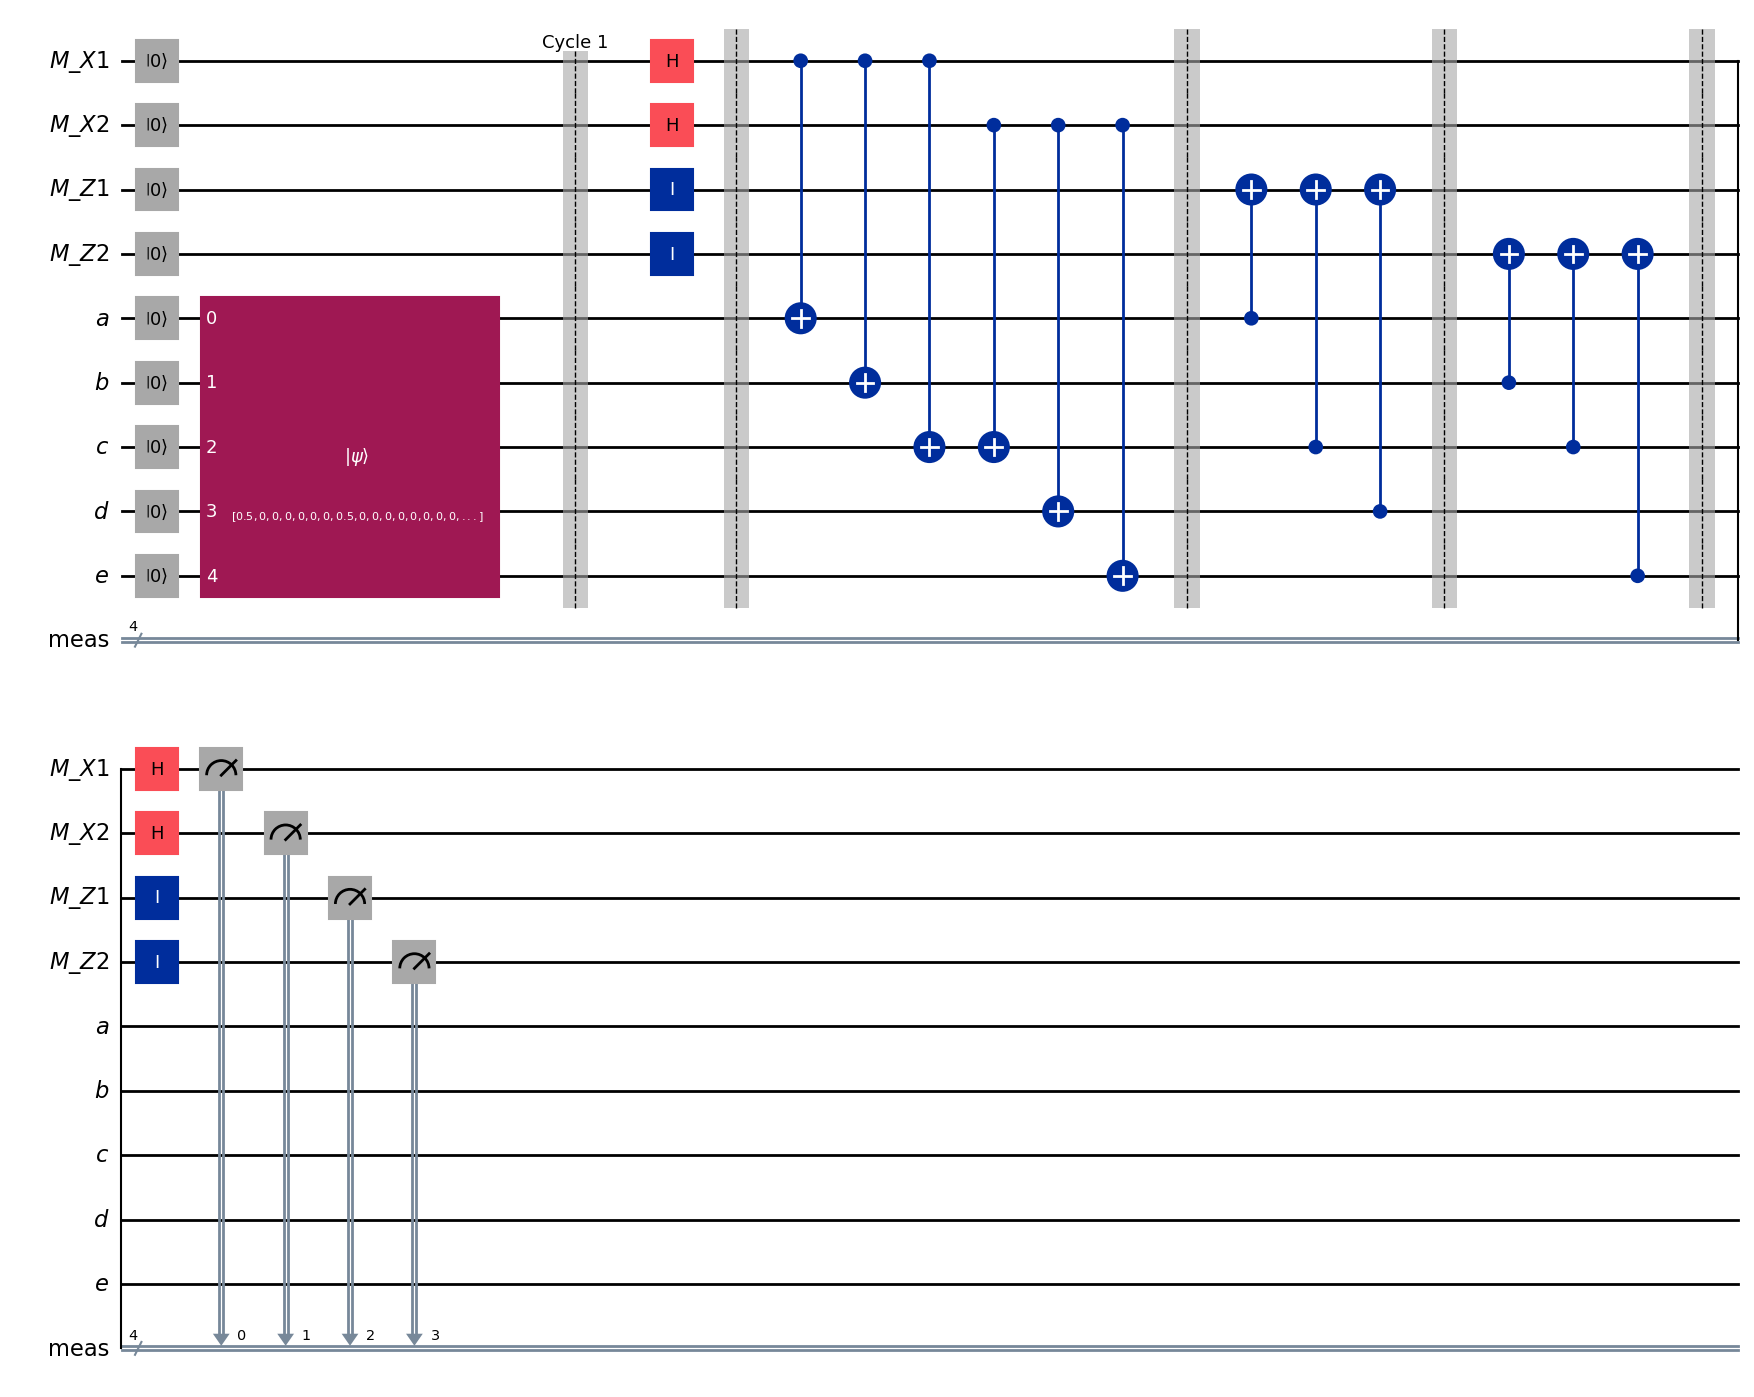

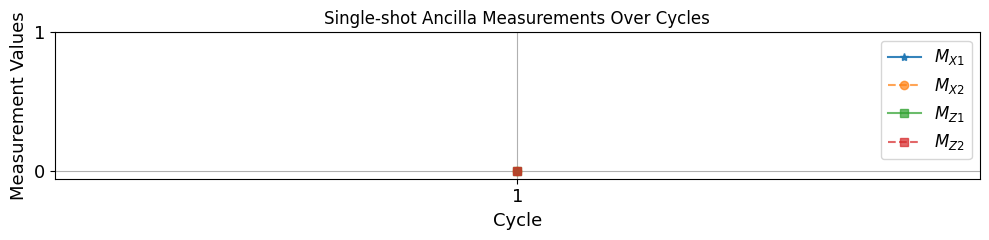

In [15]:
state_vector = logical_0_state()
nine_qubit_surface_circuit(state_vector, cycles=1, shots_num=1, draw_bool=True, measure_data_bool=False, errors=[])

Error implementation: (l,i,j,k)

- l indicates the error type {x,y,z}
- i indicates the cycle on which the error should occur {0 till cycle}
- j indicates the  data qubit {0=a,1=b,2=c,3=d,4=e}
- k indicates if the error occurs on the first or the seond identity gate {0,1}

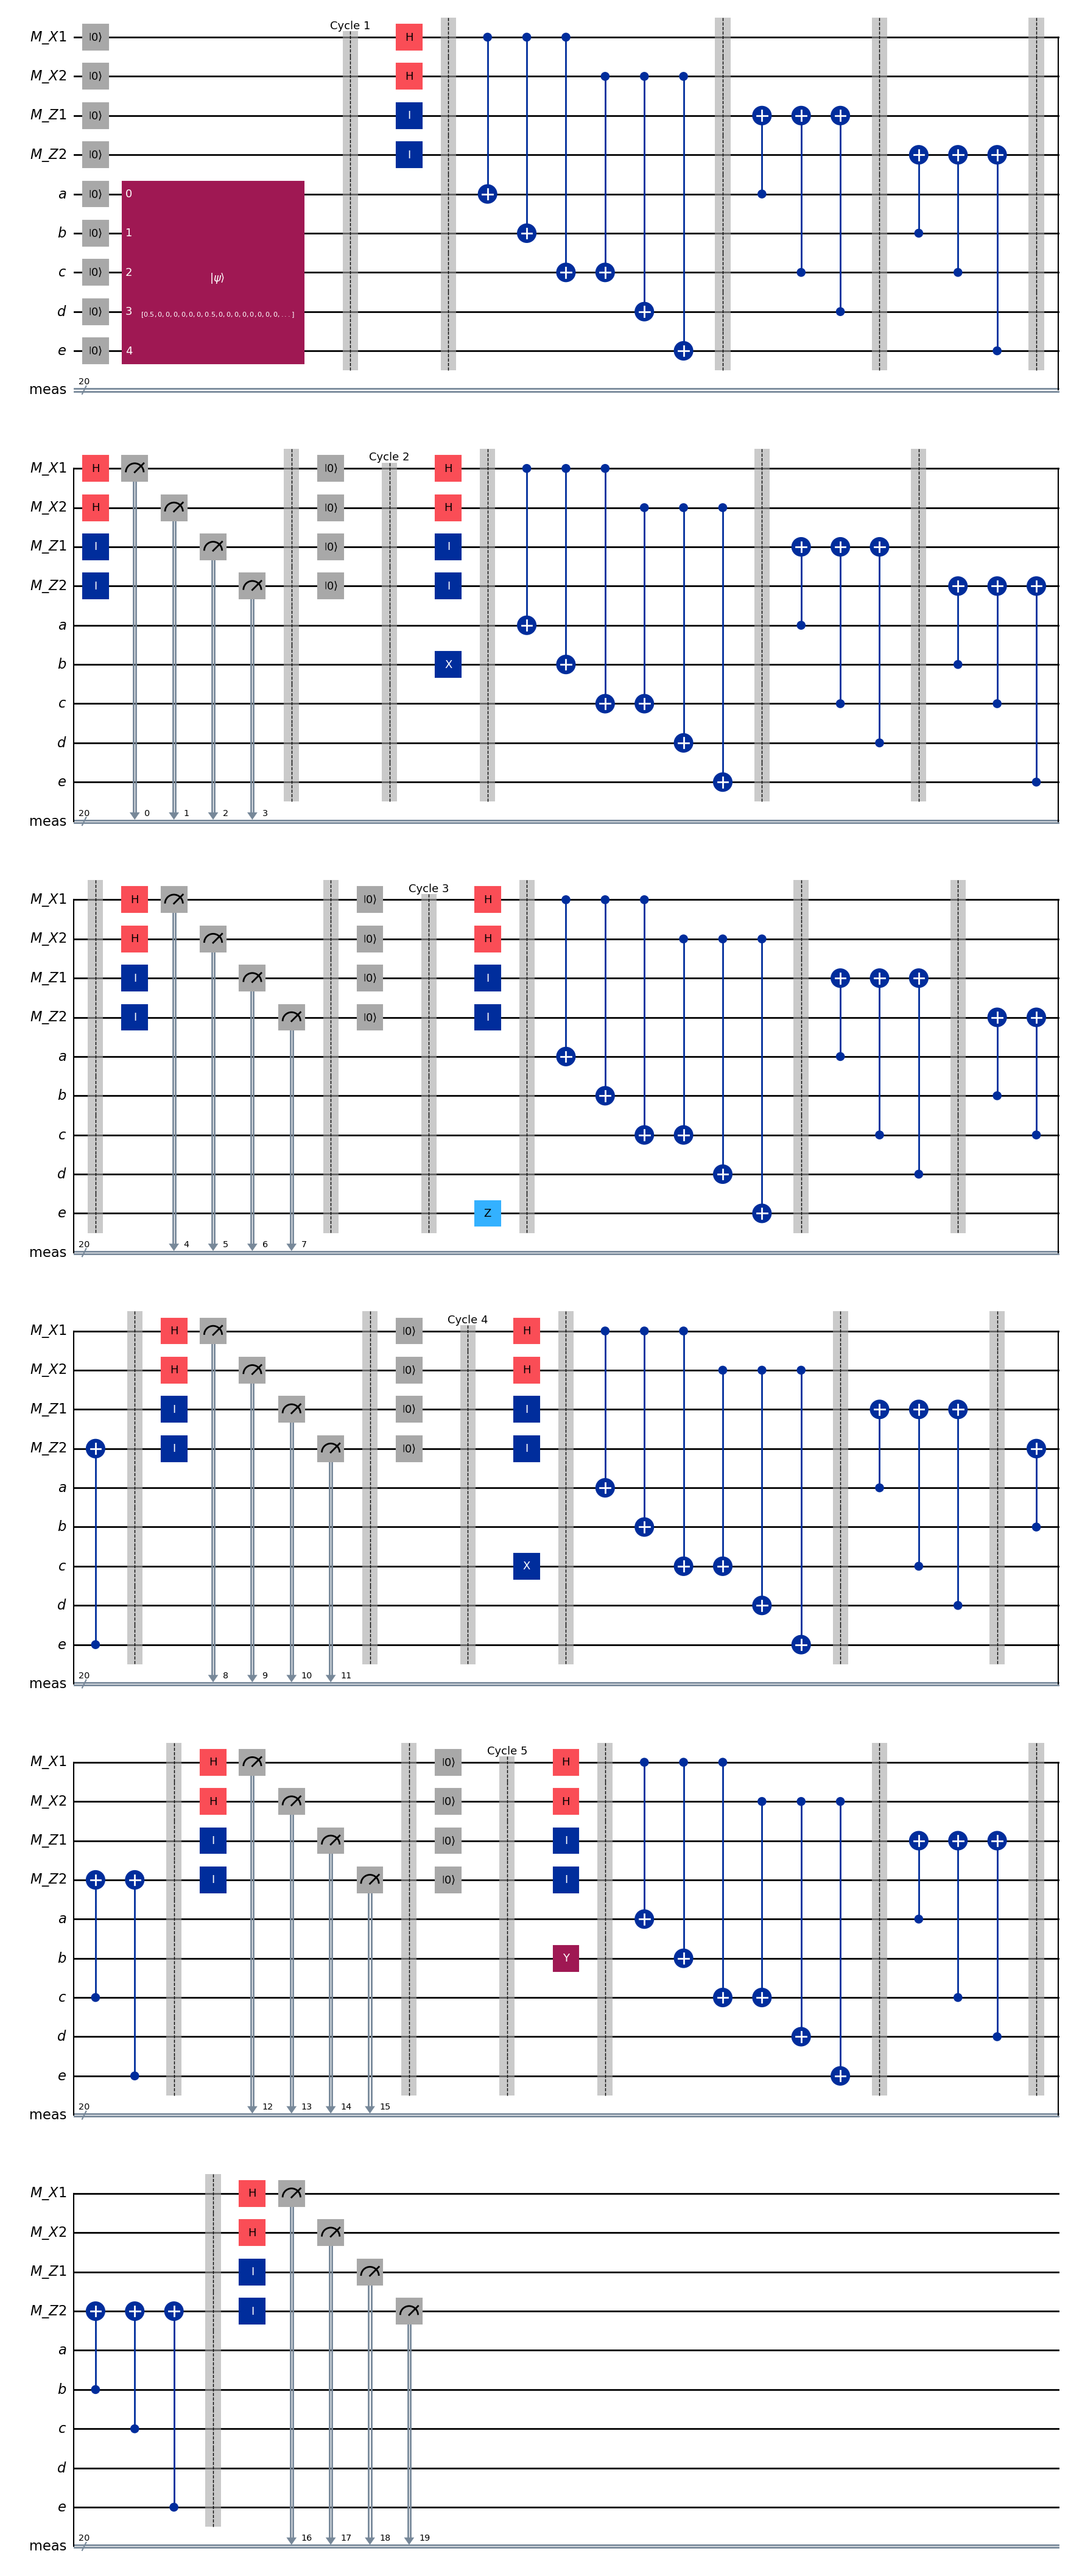

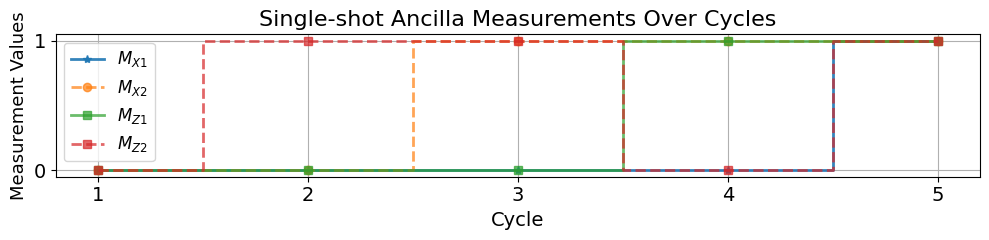

In [24]:
state_vector = logical_0_state()
errors = [('x',1,1,0),('z',2,4,0),('x',3,2,0),('y',4,1,0)]

nine_qubit_surface_circuit(state_vector, cycles=5, shots_num=1, draw_bool=True, measure_data_bool=False, errors = errors)